Source codes for Python Machine Learning By Example 2nd Edition (Packt Publishing)
Chapter 9: Stock Price Prediction with Regression Algorithms
Author: Yuxi (Hayden) Liu
modimodified by: Amadú Baldé

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [2]:
def generate_features(df):
    """
    Generate features for a stock/index based on historical price and performance
    @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
    @return: dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    # 6 original features
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 generated features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

In [3]:
data_raw = pd.read_csv('SP2000_2019Day.csv')
print("checking if any null values are present\n", data_raw.isna().sum())
data_raw.head(5)
data_raw['Date'] = pd.to_datetime(data_raw.Date,format='%Y-%m-%d')
data_raw.index = data_raw['Date']

data = generate_features(data_raw)
print("checking if any null values are present\n", data.isna().sum())

print(data.head(5))
print(data.tail(5))

checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
checking if any null values are present
 open                       0
open_1                     0
close_1                    0
high_1                     0
low_1                      0
volume_1                   0
avg_price_5                0
avg_price_30               0
avg_price_365              0
ratio_avg_price_5_30       0
ratio_avg_price_5_365      0
ratio_avg_price_30_365     0
avg_volume_5               0
avg_volume_30              0
avg_volume_365             0
ratio_avg_volume_5_30      0
ratio_avg_volume_5_365     0
ratio_avg_volume_30_365    0
std_price_5                0
std_price_30               0
std_price_365              0
ratio_std_price_5_30       0
ratio_std_price_5_365      0
ratio_std_price_30_365     0
std_volume_5               0
std_volume_30              0
std_volume_365             0
ratio_std_volume_

In [22]:
# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(data_raw.drop('Close', axis=1), data_raw['Close'], test_size=0.25)

(3626, 37)
(3626,)
(963, 37)


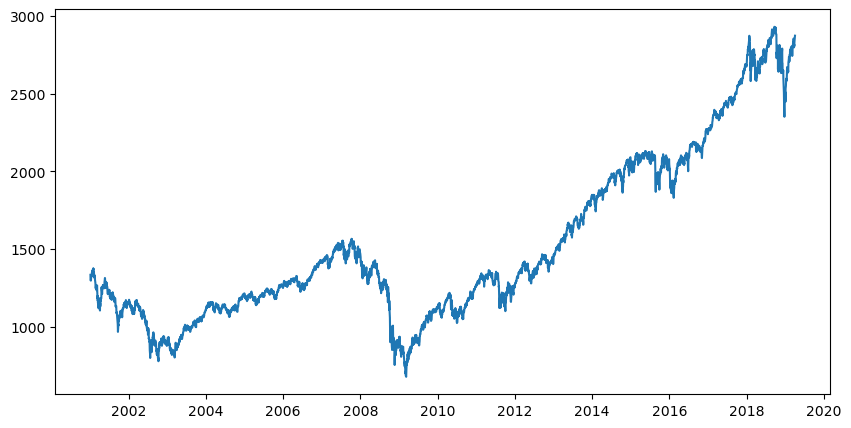

In [4]:
#plot
plt.figure(figsize=(10,5))
plt.plot(data['close'], label='close Price history')


start_train = '2001-01-03'
end_train = '2015-06-07'
    
start_test = '2015-06-08'
end_test = '2019-04-03'
    
data_train = data.loc[start_train:end_train]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values
    
print(X_train.shape)
print(y_train.shape)
    
data_test = data.loc[start_test:end_test]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values
    
print(X_test.shape)


In [5]:
# MAPE

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
# First experiment with linear regression
    
scaler = StandardScaler()
    
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
    
    
start_lr = time.time()
    
param_grid = {
        "alpha": [1e-5, 3e-5, 1e-4],
        "eta0": [0.01, 0.03, 0.1],
        }
    

In [15]:
# Regression

    
lr = SGDRegressor(penalty='l2', max_iter=1000)

#Grid search
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='r2')
grid_search.fit(X_scaled_train, y_train)
    
print(grid_search.best_params_)
    
lr_best = grid_search.best_estimator_


#Prediction
predictions_lr = lr_best.predict(X_scaled_test)
    
#Metrics
print('Linear Regression')
print('MSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lr)))
print('RMSE: {0:.3f}'.format((mean_squared_error(y_test, predictions_lr))**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lr)))
print('MAPE: {0:.3f}'.format(mean_absolute_percentage_error(y_test, predictions_lr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lr)))

    
end_lr = time.time()
print('Tempo de execução LR : %f' % (end_lr - start_lr))


ValueError: Invalid parameter max_depth for estimator SGDRegressor(). Check the list of available parameters with `estimator.get_params().keys()`.

In [8]:
# Experiment with random forest

start_rf=time.time()

param_grid = {
    'max_depth': [50, 70, 80],
    'min_samples_split': [5, 10],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [3, 5]

}


from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
rf_best = grid_search.best_estimator_

predictions_rf = rf_best.predict(X_test)

print('Random Forest Regressor')
print('MSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)))
print('RMSE: {0:.3f}'.format((mean_squared_error(y_test, predictions_rf))**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('MAPE: {0:.3f}'.format(mean_absolute_percentage_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))


end_rf=time.time()
print('Tempo de execução RF : %f' % (end_rf - start_rf))

{'max_depth': 70, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10}
Random Forest Regressor
MSE: 165298.983
RMSE: 406.570
MAE: 304.749
MAPE: 11.543
R^2: -0.801
Tempo de execução RF : 315.493154


In [ ]:
# Experiment with SVR

start_svr=time.time()

param_grid = [
    {'kernel': ['linear'], 'C': [100, 300, 500], 'epsilon': [0.00003, 0.0001]},
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [10, 100, 1000], 'epsilon': [0.00003, 0.0001]}
]


from sklearn.svm import SVR

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=2, scoring='r2')
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

svr_best = grid_search.best_estimator_

predictions_svr = svr_best.predict(X_scaled_test)

print('SVR')
print('MSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_svr)))
print('RMSE: {0:.3f}'.format((mean_squared_error(y_test, predictions_svr))**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_svr)))
print('MAPE: {0:.3f}'.format(mean_absolute_percentage_error(y_test, predictions_svr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_svr)))

end_svr = time.time()
print('Tempo de execução SVR : %f' % (end_svr - start_svr))

In [ ]:
# Experiment with neural network

start_nn=time.time()

param_grid = {
    'hidden_layer_sizes': [(50, 10), (30, 30)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.0001, 0.0003, 0.001, 0.01],
    'alpha': [0.00003, 0.0001, 0.0003],
    'batch_size': [30, 50]
}


from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(random_state=42, max_iter=2000)
grid_search = GridSearchCV(nn, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)


print(grid_search.best_params_)

nn_best = grid_search.best_estimator_

predictions_nn = nn_best.predict(X_scaled_test)

print('Neural Network')
print('MSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_nn)))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_nn)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_nn)))

end_nn=time.time()
print('Tempo de execução SVR : %f' % (end_nn - start_nn))

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(predictions_lr, color='red', label='Linear Regression')
plt.plot(predictions_rf, color='blue', label='Random Forest')
plt.plot(predictions_svr, color='green', label='SVR')
plt.plot(y_test, color = 'black', label = 'Truth')


# Add a legend in the top left corner of the plot
plt.legend(loc='upper left')

# Specify the orientation of the xticks
plt.xticks(rotation=60)

# Display the plot
plt.show()